##Mask RCNN Pre-trained Model
 

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [0]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project
PATH = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/"


/content/gdrive/My Drive/Colab Notebooks/Capstone Project


In [0]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

Build Model

In [0]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [0]:
# Import Mask RCNN
Path__new = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project"
path=sys.path.append(os.path.join(Path__new, 'Mask_RCNN'))  # To find local version of the library
print (path)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

None


Using TensorFlow backend.


In [0]:
train_dicom_dir = os.path.join(PATH, 'stage_2_train_images')
test_dicom_dir = os.path.join(PATH, 'stage_2_test_images')

In [0]:
import glob
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [0]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
#     IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200 #200
    
#     RPN_TRAIN_ANCHORS_PER_IMAGE = 16
#     TOP_DOWN_PYRAMID_SIZE = 32    
    
config = DetectorConfig() #xhb 20190525
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia_detection', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia_detection', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [0]:

anns = pd.read_csv(os.path.join(PATH, 'stage_2_train_labels.csv'))
anns.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [0]:
pip install pydicom

     |████████████████████████████████| 35.3MB 89kB/s 


In [0]:
import pydicom
ds = pydicom.read_file(image_fps[100]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [0]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw------- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [0]:
import random
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
print(image_fps_val[:6])

25184 1500
['/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/stage_2_train_images/473f3632-c6d0-4a5b-9cab-f1c6d24a7424.dcm', '/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/stage_2_train_images/6e166f1c-2999-4bd2-a8fc-01c8522aeaf0.dcm', '/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/stage_2_train_images/663773a4-0f1a-44ba-a6f3-aa0db834de5a.dcm', '/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/stage_2_train_images/e9b6311a-63a7-4443-ac67-7cccb1b905e3.dcm', '/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/stage_2_train_images/58b049d6-b48c-4edc-ac83-753591aa359d.dcm', '/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/stage_2_train_images/9d598377-c049-4aa2-a9b6-74f15b24424f.dcm']


Prepare training dataset using detector class


In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [0]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    f0343afa-3b37-47d4-93d0-9ee56c30952e
 x                                             219
 y                                             135
 width                                         189
 height                                        338
 Target                                          1
 Name: 26999, dtype: object, patientId    f0343afa-3b37-47d4-93d0-9ee56c30952e
 x                                             590
 y                                             269
 width                                         172
 height                                        466
 Target                                          1
 Name: 27000, dtype: object]

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/stage_2_train_images/a37dc7a9-8b22-461b-99d2-c77109da8220.dcm
[1 1]


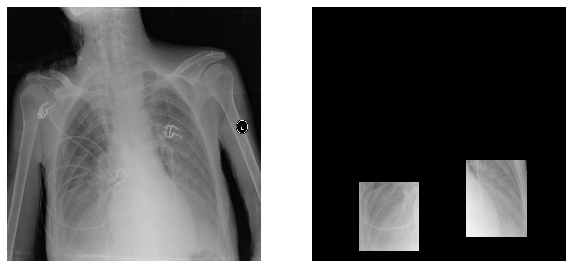

In [0]:
import cv2
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

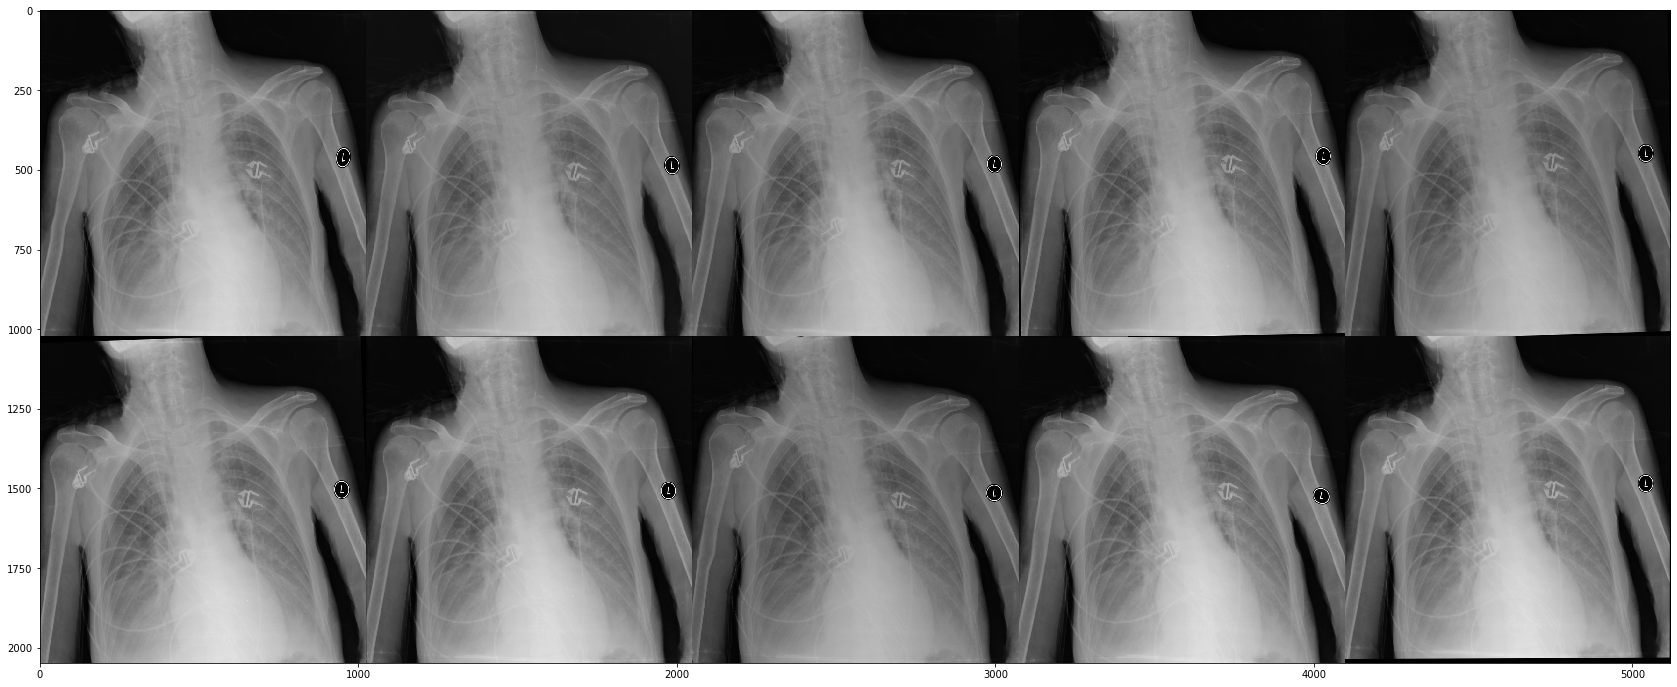

In [0]:
from imgaug import augmenters as iaa

# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [0]:
%tensorflow_version 2.x
import tensorflow

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=Path__new)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [0]:
LEARNING_RATE = 0.001

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [0]:

## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=1,
            layers='heads',
            augmentation=None)  

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/Colab Notebooks/Capstone Project/pneumonia20200314T1713/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_con

In [0]:
def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [0]:
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint_path = os.path.join(model.model_dir, "mask_rcnn_{}_*epoch*.h5".format(config.NAME.lower()))
checkpoint_path = checkpoint_path.replace("*epoch*", "{epoch:04d}")
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
callbacks = [keras.callbacks.ModelCheckpoint(checkpoint_path,monitor='val_loss',verbose=0, save_best_only=True, save_weights_only=True,period=5),lr_reduce]


In [0]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            custom_callbacks=callbacks,
            layers='all',
            augmentation=augmentation)
#history = model.keras_model.history.history
new_history = model.keras_model.history.history
history = appendHist(history, new_history)


Starting at epoch 1. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/Colab Notebooks/Capstone Project/pneumonia20200314T1713/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

ERROR:root:Error processing image {'id': 5130, 'source': 'pneumonia_detection', 'path': '/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/stage_2_train_images/3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8.dcm', 'annotations': [patientId    3c329c7a-1dcf-41c6-a3ab-1db886e8ebd8
x                                             205
y                                             465
width                                         236
height                                        207
Target                                          1
Name: 4027, dtype: object], 'orig_height': 1024, 'orig_width': 1024}
Traceback (most recent call last):
  File "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/Mask_RCNN/mrcnn/model.py", line 1211, in load_image_gt
    image = dataset.load_image(image_id)
  File "<ipython-input-10-aa13846bac16>"

200/200 [==============================] - 226s 1s/step - loss: 1.4294 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.1651 - mrcnn_bbox_loss: 0.4376 - mrcnn_mask_loss: 0.4148 - val_loss: 1.4759 - val_rpn_class_loss: 0.0140 - val_rpn_bbox_loss: 0.4375 - val_mrcnn_class_loss: 0.1275 - val_mrcnn_bbox_loss: 0.4868 - val_mrcnn_mask_loss: 0.4100
Epoch 10/30
200/200 [==============================] - 233s 1s/step - loss: 1.3259 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3867 - mrcnn_class_loss: 0.1541 - mrcnn_bbox_loss: 0.3938 - mrcnn_mask_loss: 0.3800 - val_loss: 1.3067 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.3556 - val_mrcnn_class_loss: 0.1578 - val_mrcnn_bbox_loss: 0.4122 - val_mrcnn_mask_loss: 0.3710

Epoch 00010: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 11/30
200/200 [==============================] - 240s 1s/step - loss: 1.2836 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3549 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_los

In [0]:
epochs = range(1,len(next(iter(history.values())))+1)
mRcnn_dataframe=pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.835267,0.021963,0.488998,0.275628,0.648146,0.400531,1.878729,0.027326,0.522735,0.239705,0.639244,0.449718
2,1.649189,0.015719,0.410678,0.223686,0.585410,0.413689,1.672428,0.020749,0.539277,0.209082,0.493371,0.409941
3,1.592779,0.015108,0.491440,0.180402,0.525270,0.380552,1.542464,0.013008,0.443648,0.178879,0.478160,0.428762
4,1.852848,0.019482,0.689071,0.159228,0.598996,0.386065,1.612302,0.013202,0.529087,0.189818,0.467394,0.412794
5,1.655696,0.014933,0.665761,0.140730,0.415174,0.419091,1.459092,0.014270,0.428410,0.201273,0.435680,0.379451
6,1.532796,0.013172,0.461672,0.254722,0.432658,0.370566,1.546581,0.014034,0.461114,0.210842,0.452408,0.408176
7,1.361172,0.012237,0.344601,0.200484,0.415618,0.388225,1.418903,0.012003,0.418991,0.193285,0.409810,0.384807
8,1.635397,0.013282,0.493254,0.149980,0.526004,0.452870,1.375173,0.012050,0.417185,0.167053,0.402565,0.376313
9,1.475852,0.014009,0.437476,0.127544,0.486786,0.410029,1.429398,0.011261,0.400661,0.165129,0.437562,0.414778
10,1.306670,0.010095,0.355593,0.157830,0.412187,0.370957,1.325921,0.011223,0.386736,0.154118,0.393804,0.380033


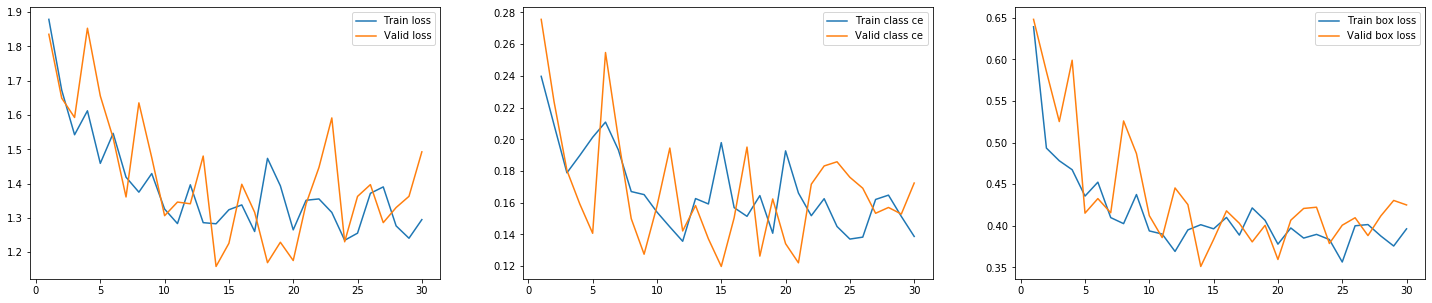

In [0]:

plt.figure(figsize=(25,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [0]:
 if not os.path.exists('/content/gdrive/My Drive/Colab Notebooks/created3_csv'):
     os.makedirs('/content/gdrive/My Drive/Colab Notebooks/created3_csv')
 mRcnn_dataframe.to_csv(r'/content/gdrive/My Drive/Colab Notebooks/created3_csv/mRcnn_history.csv')

In [0]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 14 1.1587164151668548


In [0]:
model_path ='/content/gdrive/My Drive/Colab Notebooks/Capstone Project/pneumonia20200314T1713/mask_rcnn_pneumonia_0014.h5'

In [0]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=model.model_dir)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/gdrive/My Drive/Colab Notebooks/Capstone Project/pneumonia20200314T1713/mask_rcnn_pneumonia_0014.h5
Re-starting from epoch 14


In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 



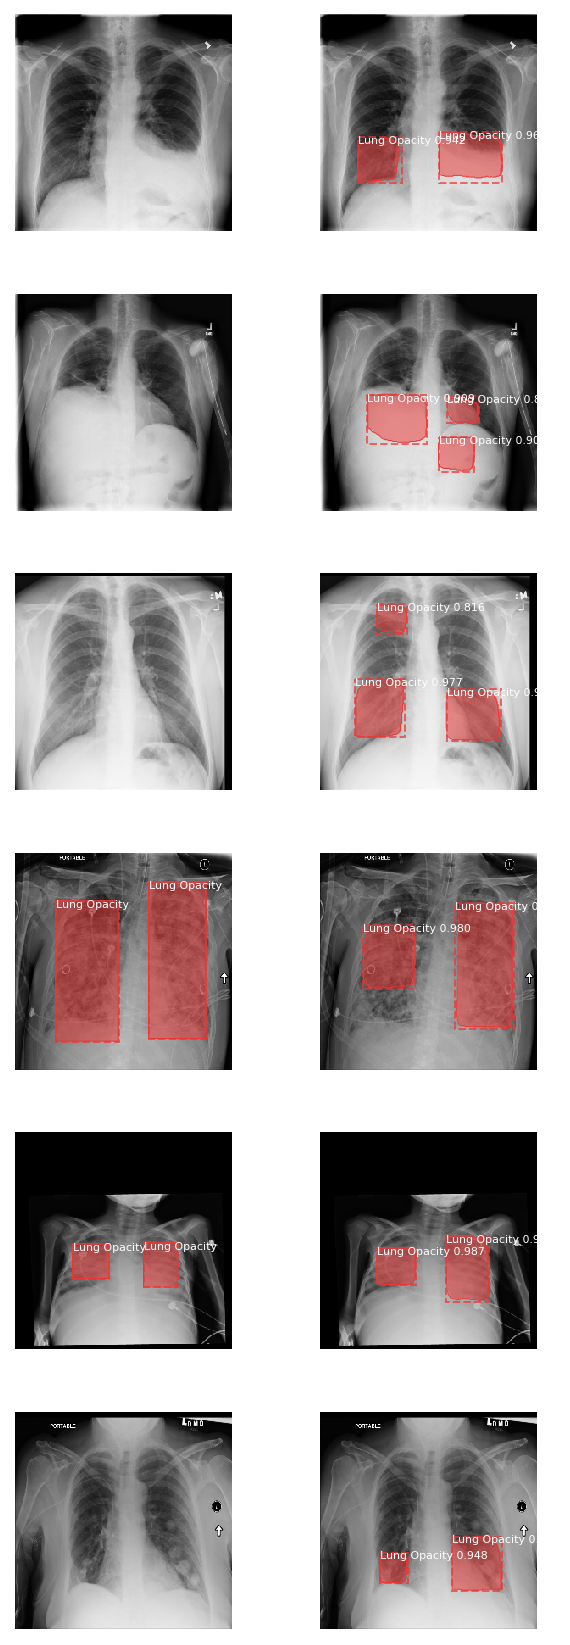

In [0]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 



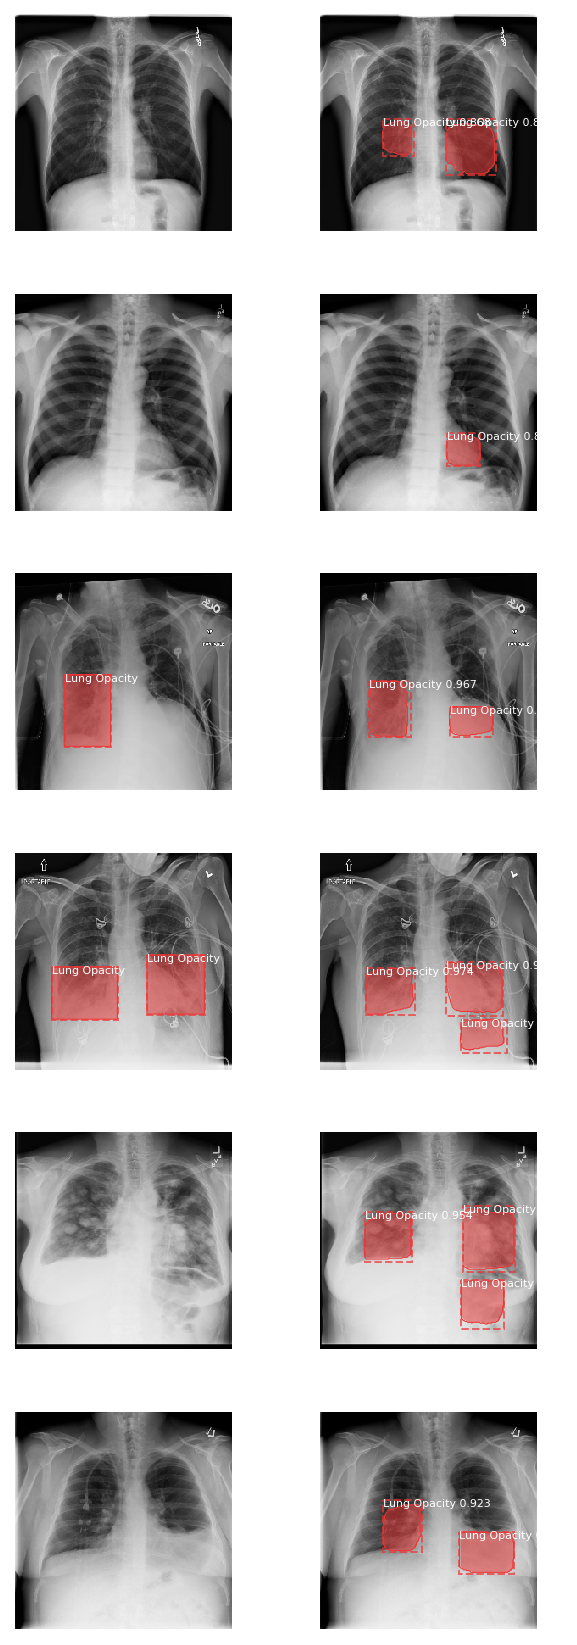

In [0]:
# Show few example of ground truth vs. predictions on the training dataset 
dataset = dataset_train
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [0]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [0]:
from tqdm import tqdm
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [0]:
# predict only the first 50 entries
sample_submission_fp = model.model_dir+'/submission.csv'
predict(test_image_fps, filepath=sample_submission_fp)

100%|██████████| 3000/3000 [28:34<00:00,  1.90it/s]


In [0]:
output = pd.read_csv(sample_submission_fp)
output.head(50)

,patientId,PredictionString
0,0e5803f0-1653-4099-932c-e3df9f402772,0.95 584.0 520.0 260.0 196.0
1,1b6345c7-0d2c-4b43-b214-a5b43d69ac87,0.98 176.0 552.0 280.0 296.0
2,2d74db0e-9a5a-4763-8451-ad653405c3ab,0.98 224.0 524.0 228.0 224.0 0.95 596.0 520.0...
3,1a5eef1c-c817-4c73-9e8b-d75eae0e4c0a,0.98 636.0 388.0 268.0 436.0 0.95 192.0 540.0...
4,042d37c9-b83f-40f6-8d8e-85022c7f3a14,0.97 260.0 388.0 192.0 152.0 0.95 628.0 396.0...
5,0ffb49c2-51e5-47dd-bfb9-2fe300e697e8,0.98 584.0 484.0 184.0 308.0 0.97 280.0 488.0...
6,11436729-e5c7-40a4-b7b2-bfec506b6fed,NaN
7,129cc66d-d78f-4122-a439-933268ea5c00,0.95 624.0 516.0 160.0 200.0
8,1f27caf8-fe15-47cd-915e-18999274bcb3,0.96 180.0 484.0 252.0 260.0
9,306046b1-6d19-42f0-8cde-98c84f923afa,0.97 160.0 176.0 264.0 660.0 0.96 612.0 596.0...


011b475b-4b74-4857-8221-d15d71ba64a9
[115  79 167 146]
x 316 y 460 h 268 w 208
[ 93 183 130 229]
x 732 y 372 h 184 w 148
21f202b2-fa91-490b-9e48-8cb38078a7c8
[205 145 241 194]
x 580 y 820 h 196 w 144
[131  71 170 114]
x 284 y 524 h 172 w 156
[113 155 182 212]
x 620 y 452 h 228 w 276
1a70a918-bcde-4eca-806f-d875867a1a01
[115 156 163 208]
x 624 y 460 h 208 w 192
[118  53 167 104]
x 212 y 472 h 204 w 196
1defec61-9293-49ff-81ae-7246c77d489c
[ 89  72 177 126]
x 288 y 356 h 216 w 352
[104 161 197 219]
x 644 y 416 h 232 w 372
[ 27  89  83 126]
x 356 y 108 h 148 w 224


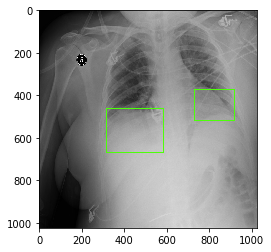

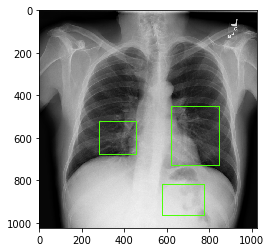

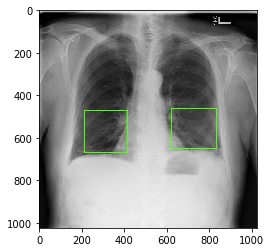

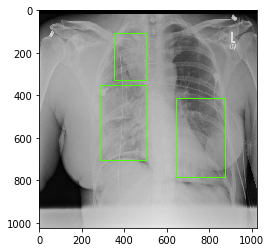

In [0]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()